In [100]:
# Library Import

import json
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 

In [2]:
# Get list of all 50 stocks covered in Nifty-50 as of 18-04-2019

f = open('index.txt')
lines = list(f)
indices = [i.strip('\n') for i in lines]
f.close()

In [3]:
# main_dict[i] => datewise data of each stock i (not in sorted order)
# close----high----low----open----volume

main_dict = {}
for i in tqdm(indices[1:]):
#     print(i)
    fn='JSON/'+i+'.json'
    f = open(fn)
    lines = list(f)
    lines = lines[0]
    data = json.loads(lines)
    main_dict[i] = dict(sorted(data['history'].items(), reverse=True))

100%|██████████| 50/50 [00:00<00:00, 72.93it/s]


In [5]:
# populate the rows in main_history with dates which are present in all
# 50 stocks in (sorted order)
# main_history[0] => 18-04-2019
# main_history[-1] => 23-07-2013
# 1401 dates in total

main_history = []
fn='JSON/'+'NIFTY'+'.json'
f = open(fn)
lines = list(f)
lines = lines[0]
data = json.loads(lines)
history = sorted(data['history'].items(), reverse=True)
for i in tqdm(history):
    flag = 0
    for j in indices[1:]:
        if i[0] not in main_dict[j]:
            flag = 1
            break
    if flag==0:
        temp = {}
        for j in indices[1:]:
            temp[j] = main_dict[j][i[0]]['close']
        main_history.append((i[0],temp,i[1]['close']))

100%|██████████| 4869/4869 [00:00<00:00, 31031.86it/s]


In [11]:
# list of tuples
# list[0] => date
# list[1] => {'close': , 'high': , 'low': , 'open': , 'volume': }

nifty_data = history

In [17]:
def list_attribute(colname):
    temp = []
    for i in nifty_data:
        temp.append(float(i[1][colname]))
    return temp

In [22]:
close_nifty = np.array(list_attribute('close'))[::-1]

# last value is the most recent one

In [64]:
dates = [nifty_data[i][0] for i in range(len(nifty_data))][::-1]

In [32]:
SC = StandardScaler()
scaled_nifty = SC.fit_transform(close_nifty.reshape(-1,1))

In [44]:
train_size = int((0.6)*(len(scaled_nifty)))
val_size = int(0.2*(len(scaled_nifty)))
test_size = len(scaled_nifty)-train_size-val_size

train_set = scaled_nifty[:train_size] 
val_set = scaled_nifty[train_size:train_size+val_size]
test_set = scaled_nifty[train_size+val_size:]

In [198]:
def training_validation(time_step, time_horizon):
    regressor = LinearRegression(fit_intercept=True)
    predictions = []

    for i in range(train_size+val_size, train_size+val_size+test_size):
        X_train = np.array(range(len(scaled_nifty[i-time_step:i])))
        Y_train = np.array(scaled_nifty[i-time_step-time_horizon:i-time_horizon])
        X_train = X_train.reshape(-1,1)
        Y_train = Y_train.reshape(-1,1)

        regressor.fit(X_train, Y_train)
        predicted = regressor.predict(np.array([time_step-1+time_horizon]).reshape(-1,1))
        predictions.append(predicted)
    
    return np.array([i[0] for i in predictions])

In [187]:
mse=[]
for j in tqdm(range(2,31)):
    temp = []
    for k in range(1,11):
        predicted_vals = training_validation(j, k)
        temp.append(mean_squared_error(val_set, predicted_vals))
    mse.append(temp)

100%|██████████| 29/29 [01:24<00:00,  2.94s/it]


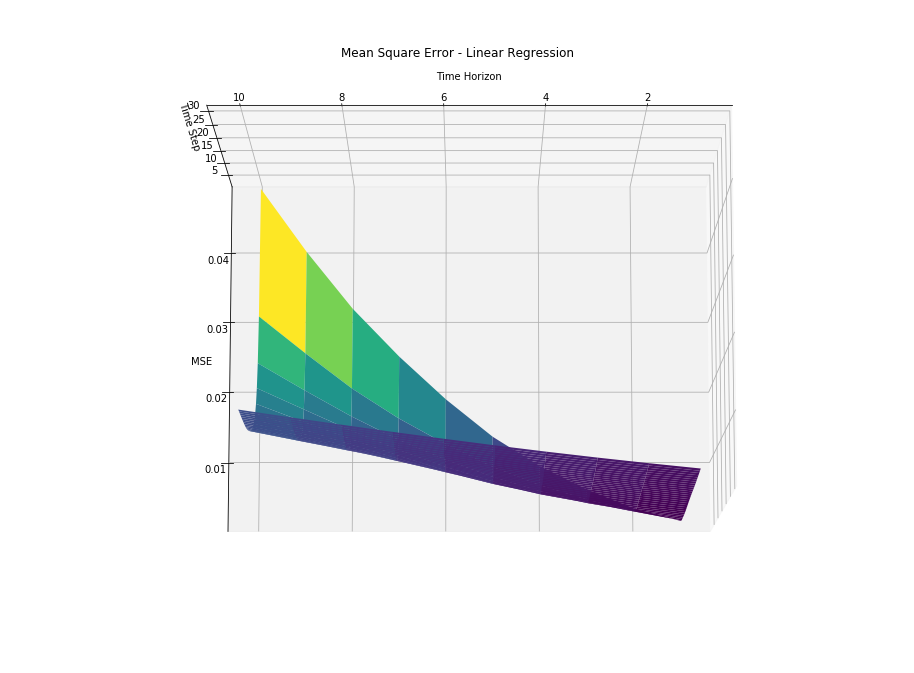

In [195]:
x = range(2,31)
y = range(1,11)

X, Y = np.meshgrid(y, x)
Z = mse

fig = plt.figure(figsize=(16,12))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.set_title('Mean Square Error - Linear Regression')
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Time Step')
ax.set_zlabel('MSE')

ax.view_init(-10, 90)
# fig.savefig('which-timestep-is-better-for-which-horizon1_30TH.png')

In [202]:
# time-step, time-horizon

predicted_vals = training_validation(3, 1)
print(mean_squared_error(test_set, predicted_vals))
predictions = SC.inverse_transform(predicted_vals)
actual = SC.inverse_transform(test_set)

0.001591303441337874


In [203]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd
from datetime import datetime

data = [go.Scatter(x=dates[train_size+val_size:], y=actual, name='Actual'),
        go.Scatter(x=dates[train_size+val_size:], y=predictions, name='Predicted')]

py.iplot(data, filename = 'nifty-50')